# Simulation and inference of degree-corrected Poisson RGG

$$P(G|D, \theta, k) = \prod_{i<j} \frac{(k_i k_j \mathcal{F}(D_{ij}, \theta))^{A_{ij}}}{A_{ij}!} \exp(- k_i k_j \mathcal{F}(D_{ij}, \theta))$$

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import sys
sys.path.append('../../utils')

In [3]:
from graphs import (get_independent_components_rgg, make_inter_vertex_distances, 
                    deg_corrected_poissonian_random_geometric_graph)

In [4]:
from plot import plot_multigraph
from networkx.linalg.graphmatrix import adjacency_matrix
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import math
import arviz as az
from time import time

In [5]:
import nest_asyncio
nest_asyncio.apply()
import stan

In [6]:
SEED = 42
n = 10
dim = 2

In [7]:
lambda_r_truth = 2
exponential_kernel = lambda dist, ki, kj: ki * kj * math.exp(-lambda_r_truth * dist)

In [8]:
kolness_truth = np.ones(n)
kolness_truth[0] = 10

In [9]:
r = np.random.RandomState(SEED)
G_poisson = deg_corrected_poissonian_random_geometric_graph(
    n, 1000, kolness_truth, exponential_kernel, r, 
)

In [10]:
adj = adjacency_matrix(G_poisson)
adj = adj.toarray()

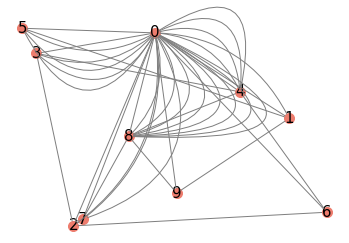

In [11]:
ax = plot_multigraph(G_poisson)

In [12]:
distances = make_inter_vertex_distances(G_poisson)

## Inference

In [13]:
from scipy.stats import expon

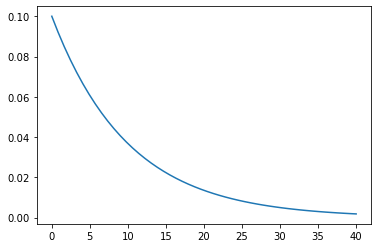

In [14]:
x = np.linspace(0,40)
pdf = expon.pdf(x, scale = 1./0.1)
plt.plot(x, pdf)

In [15]:
def make_dc_poisson_rgg_model(n_physicians):
    model = f"""
    data {{
        array[{n_physicians}, {n_physicians}] real<lower=0> distances;
        array[{n_physicians}, {n_physicians}] int<lower=0> adj;                                
    }}
    parameters {{
        real<lower=0> lambda_r;        
        array[{n_physicians}] real<lower=0> kolness;
    }}
    transformed parameters {{        
    }}
    model {{        
        lambda_r ~ exponential(0.1);
        kolness ~ exponential(0.1);
        
        for (i in 1:{n_physicians})
            for (j in i+1:{n_physicians})                
                adj[i,j] ~ poisson(kolness[i] * kolness[j] * exp(-lambda_r * distances[i,j]));        
    }}
    """
    return model

In [16]:
poisson_rgg_model_dc = make_dc_poisson_rgg_model(n)

In [17]:
poisson_rgg_data = {'distances': distances, 'adj': adj}

In [18]:
posterior = stan.build(poisson_rgg_model_dc, data=poisson_rgg_data, random_seed=SEED)

Building...



Building: found in cache, done.

In [19]:
fit = posterior.sample(num_chains=4, num_samples=1000)

Sampling:   0%
Sampling:  25% (2000/8000)
Sampling:  50% (4000/8000)
Sampling:  75% (6000/8000)
Sampling: 100% (8000/8000)
Sampling: 100% (8000/8000), done.
Messages received during sampling:
  Gradient evaluation took 8.7e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.87 seconds.
  Adjust your expectations accordingly!
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: poisson_lpmf: Rate parameter is -nan, but must be nonnegative! (in '/tmp/httpstan_a0ppkf6w/model_6phtw25d.stan', line 18, column 16 to column 94)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Gradient evaluation took 3e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.3 seconds.
  A

In [20]:
inferred = az.from_pystan(fit)

In [21]:
summary = az.summary(inferred) # , var_names = ['lambda_r', 'kolness']
summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
lambda_r,3.254,0.880,1.612,4.853,0.030,0.021,1121.0,699.0,1.0
kolness[0],13.968,4.966,5.729,23.372,0.109,0.077,1486.0,783.0,1.0
kolness[1],0.980,0.488,0.225,1.896,0.007,0.005,4428.0,2143.0,1.0
kolness[2],1.806,0.814,0.534,3.293,0.014,0.010,2739.0,2149.0,1.0
kolness[3],0.896,0.400,0.246,1.650,0.005,0.004,5229.0,2603.0,1.0
kolness[4],1.298,0.477,0.506,2.193,0.006,0.005,5233.0,2779.0,1.0
kolness[5],1.014,0.462,0.290,1.878,0.007,0.005,4410.0,2932.0,1.0
kolness[6],1.836,1.226,0.220,4.054,0.023,0.016,1754.0,1032.0,1.0
kolness[7],1.626,0.711,0.462,2.916,0.012,0.008,3097.0,2097.0,1.0
kolness[8],2.216,0.751,0.965,3.662,0.012,0.008,3975.0,2701.0,1.0


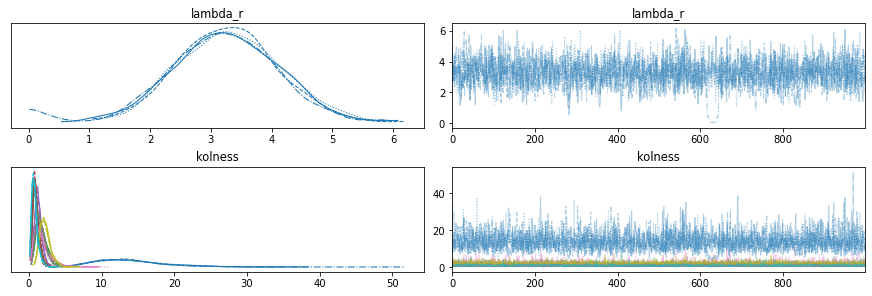

In [22]:
az.plot_trace(inferred, var_names = ['lambda_r', 'kolness']);

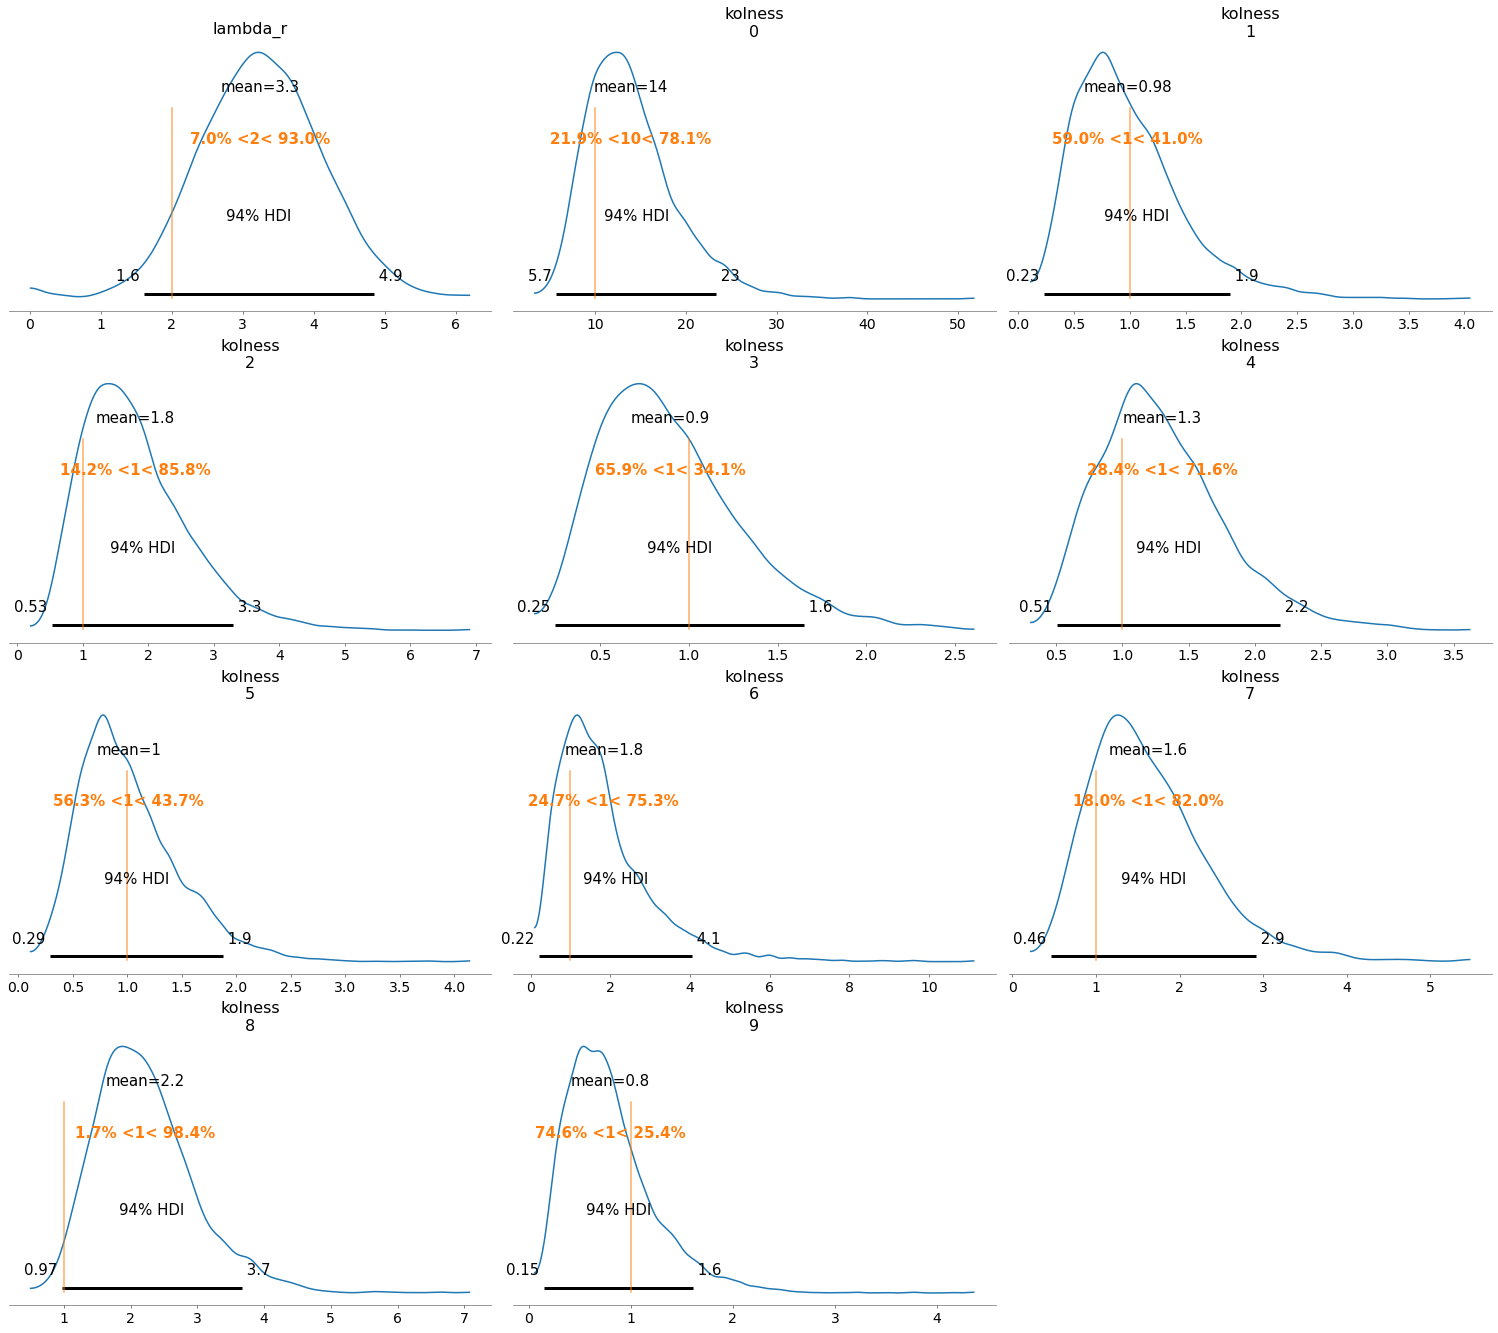

In [23]:
az.plot_posterior(inferred, var_names = ['lambda_r', 'kolness'], ref_val = [lambda_r_truth] + list(kolness_truth));

Text(0, 0.5, 'Posterior mean')

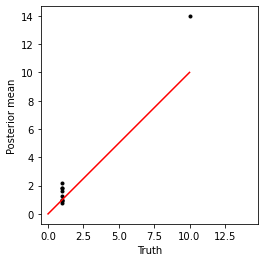

In [24]:
fig, ax = plt.subplots()
ax.plot(kolness_truth, summary.loc[[f'kolness[{i}]' for i in range(n)], 'mean'], '.k')

x = np.linspace(0,max(kolness_truth))
ax.plot(x, x, '-r', label='identity')
ax.axis('square')

ax.set_xlabel('KOLness (truth)')
ax.set_ylabel('Inferred KOLness (Posterior mean)')
ax.legend();

## Large numbers of physicians

In [25]:
from seaborn import heatmap

In [26]:
r = np.random.RandomState(SEED)

n = 500  # number of physicians
n_kol = int(0.1*n)  # number of KOLs

kolness_truth = np.ones(n)
kolness_truth[:n_kol] = r.uniform(3,7, size=n_kol)

G_poisson = deg_corrected_poissonian_random_geometric_graph(
    n, 1000, kolness_truth, exponential_kernel, r, 
)

adj = adjacency_matrix(G_poisson)
adj = adj.toarray()

distances = make_inter_vertex_distances(G_poisson)

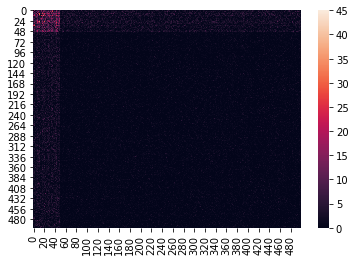

In [27]:
heatmap(adj);

In [28]:
poisson_rgg_model_dc = make_dc_poisson_rgg_model(n)

In [29]:
poisson_rgg_data = {'distances': distances, 'adj': adj}

In [30]:
posterior = stan.build(poisson_rgg_model_dc, data=poisson_rgg_data, random_seed=SEED)

Building...



Building: found in cache, done.

In [33]:
start = time()
fit = posterior.sample(num_chains=4, num_samples=1000)
duration = time() - start
print(f'Took {duration}s to finish')

Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampling:  18% (1400/8000)
Sampling:  19% (1500/8000)
Sampling:  20% (1600/8000)
Sampling:  21% (1700/8000)
Sampling:  22% (1800/8000)
Sampling:  24% (1900/8000)
Sampling:  25% (2000/8000)
Sampling:  26% (2100/8000)
Sampling:  28% (2200/8000)
Sampling:  29% (2300/8000)
Sampling:  30% (2400/8000)
Sampling:  31% (2500/8000)
Sampling:  32% (2600/8000)
Sampling:  34% (2700/8000)
Sampling:  35% (2800/8000)
Sampling:  36% (2900/8000)
Sampling:  38% (3000/8000)
Sampling:  39% (3100/8000)
Sampling:  40% (3200/8000)
Sampling:  41% (3300/8000)
Samplin

Took 1646.1441650390625s to finish


In [41]:
duration/60

27.435736083984374

In [34]:
inferred = az.from_pystan(fit)

In [35]:
summary = az.summary(inferred)

In [36]:
summary.shape

(501, 9)

In [37]:
summary.index

Index(['lambda_r', 'kolness[0]', 'kolness[1]', 'kolness[2]', 'kolness[3]',
       'kolness[4]', 'kolness[5]', 'kolness[6]', 'kolness[7]', 'kolness[8]',
       ...
       'kolness[490]', 'kolness[491]', 'kolness[492]', 'kolness[493]',
       'kolness[494]', 'kolness[495]', 'kolness[496]', 'kolness[497]',
       'kolness[498]', 'kolness[499]'],
      dtype='object', length=501)

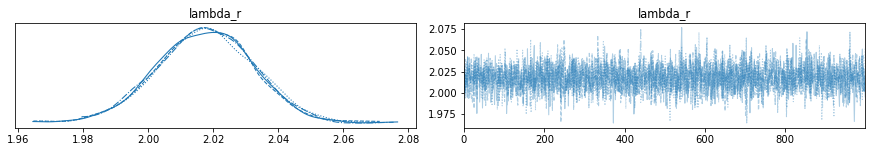

In [45]:
az.plot_trace(inferred, var_names = ['lambda_r']);
plt.savefig(f'trace-{n}.png')

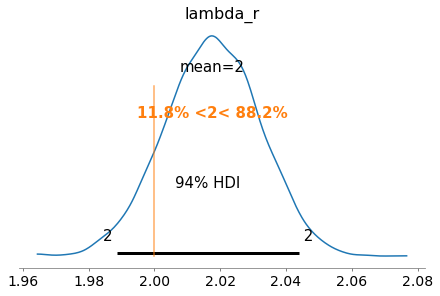

In [44]:
az.plot_posterior(inferred, var_names = ['lambda_r'], ref_val = [lambda_r_truth]);
plt.savefig(f'lambda-r-{n}.png')

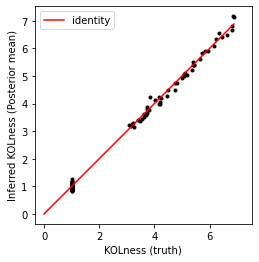

In [43]:
fig, ax = plt.subplots()
ax.plot(kolness_truth, summary.loc[[f'kolness[{i}]' for i in range(n)], 'mean'], '.k')

x = np.linspace(0,max(kolness_truth))
ax.plot(x, x, '-r', label='identity')
ax.axis('square')

ax.set_xlabel('KOLness (truth)')
ax.set_ylabel('Inferred KOLness (Posterior mean)')
ax.legend();
plt.savefig(f'kolness-vs-truth-{n}.png')